# Covid-19 Detection Using a Convolutional Neural Network

## About Dataset



#### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import cv2
import imutils

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

%matplotlib inline

## Data Loading and Preprocessing

### Function to load and preprocess data

1. Read the image
2. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
3. Apply normalization because we want pixel values to be scaled to the range 0-1.
4. Append the image to X and its label to y.
5. Shuffle data and return X and Y

In [2]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'Covid', otherwise append 0.
            if directory[-5:] == 'Covid':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Loading dataset from covid19-dataset

In [3]:
augmented_data_base_path = 'resources\\augumented_dataset\\covid19-dataset\\'

# augmented data (yes and no) contains both the original and the new generated examples
covid = augmented_data_base_path + 'Covid' 
normal = augmented_data_base_path + 'Normal'
pneumonia = augmented_data_base_path + 'Viral Pneumonia'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([covid, normal, pneumonia], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1156
X shape is: (1156, 240, 240, 3)
y shape is: (1156, 1)


### Function to print Data Summary

In [4]:
def data_summary(main_path):
    
    covid_path = main_path+'Covid'
    normal_path = main_path+'Normal'
    viral_path = main_path+'Viral Pneumonia'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(covid_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(normal_path)) + len(listdir(viral_path)) 
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

Printing data summary

In [5]:
data_summary(augmented_data_base_path)

Number of examples: 1156
Percentage of positive examples: 53.28719723183391%, number of pos examples: 616
Percentage of negative examples: 46.71280276816609%, number of neg examples: 540


### Function to plot sample 50 Covid positive and 50 Covid negative images 

In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Covid-19 Positive: {label_to_str(label)}")
        plt.show()

### Plotting sample images for visualization purposes

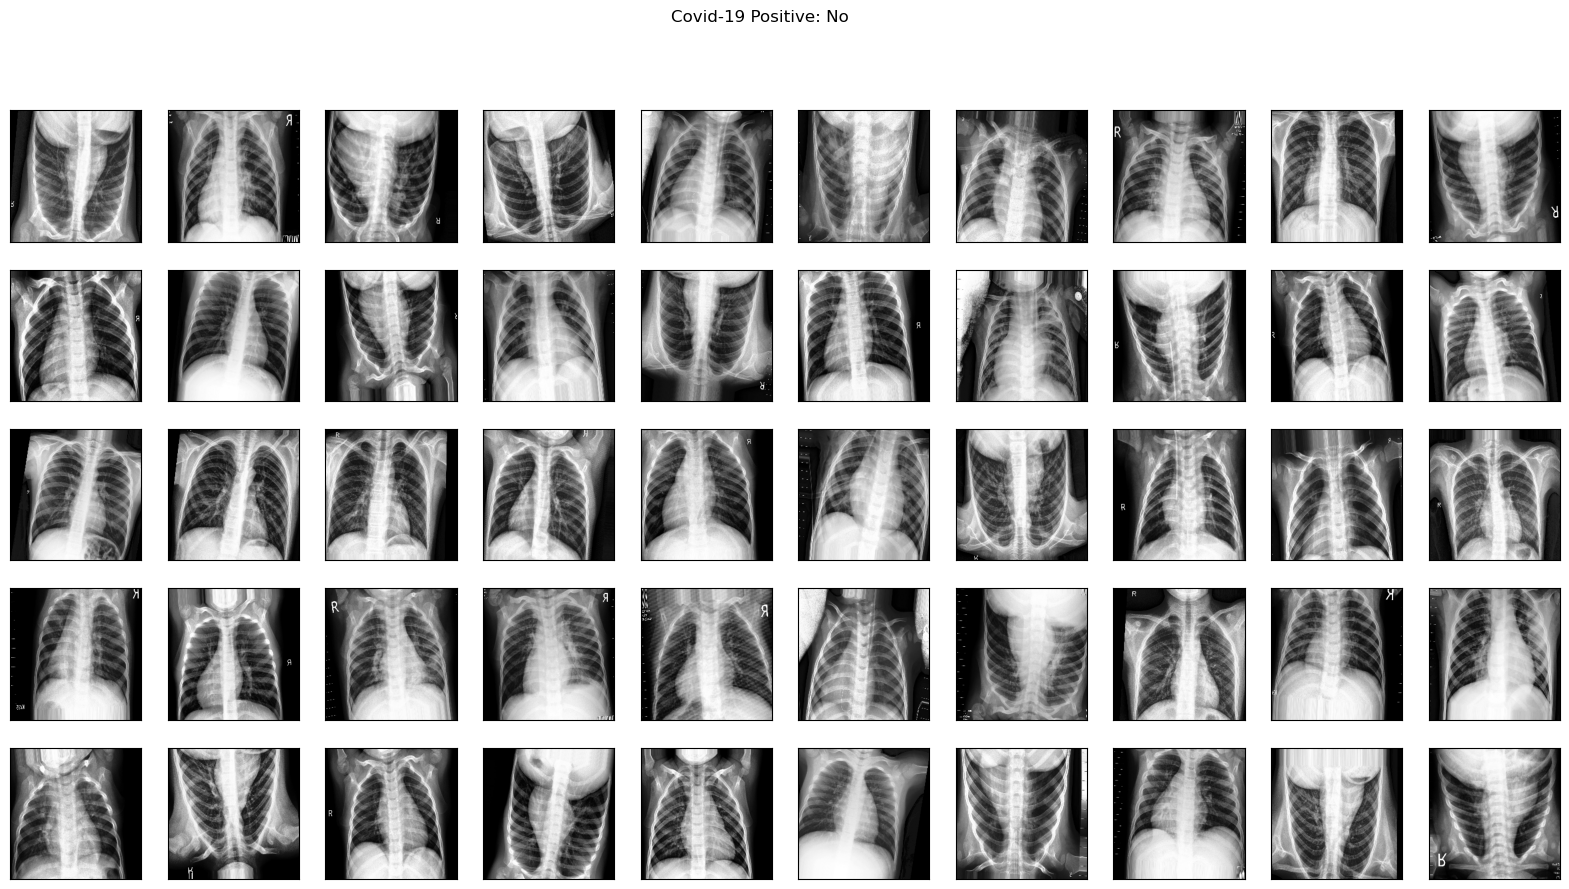

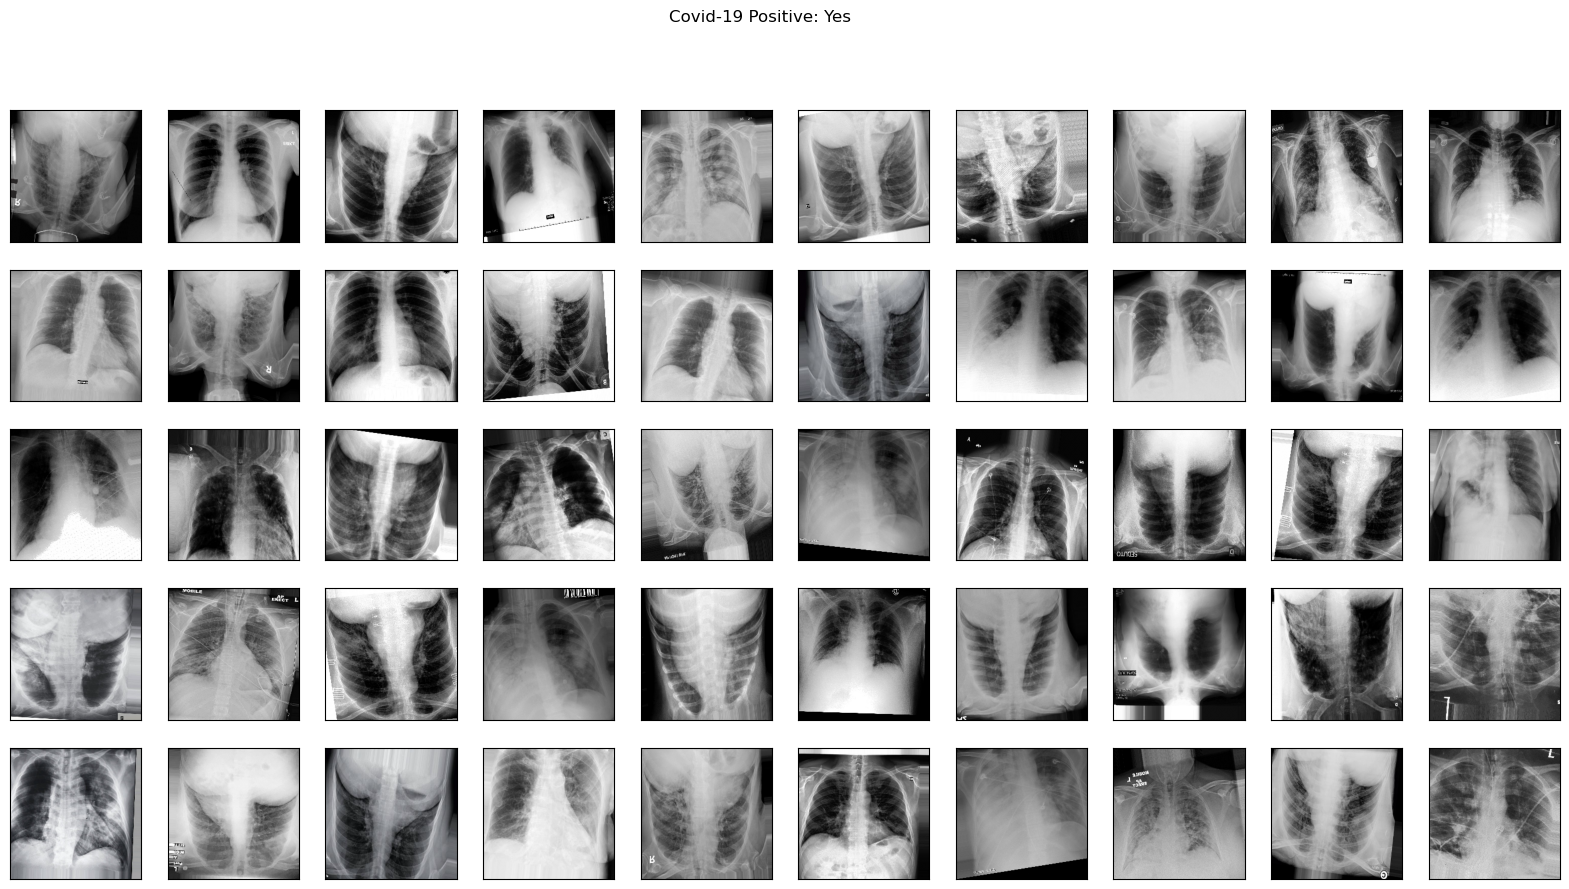

In [7]:

plot_sample_images(X, y)

### Function to split data into Training, Cross-Validation and Test set

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### Splitting the data 
- 70% Training Set
- 15% Cross-validation Set
- 15% Test Set

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

Split Metrics

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 809
number of development examples = 174
number of test examples = 173
X_train shape: (809, 240, 240, 3)
Y_train shape: (809, 1)
X_val (dev) shape: (174, 240, 240, 3)
Y_val (dev) shape: (174, 1)
X_test shape: (173, 240, 240, 3)
Y_test shape: (173, 1)


## Build Model

Helper Functions

In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

### Neural Network Architecture

<!-- ![](resources\convnet_architecture.jpg) -->

Function to Build Neral Network

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CovidDetectionModel')
    
    return model

Define the image shape:

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "CovidDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'covid_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model


Tarining for 10 epochs and 30 batch size 

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
26/26 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6749

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.51.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.51.model\assets


26/26 [==============================] - 29s 779ms/step - loss: 0.7488 - accuracy: 0.6749 - val_loss: 0.8200 - val_accuracy: 0.5057
Epoch 2/20
26/26 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9023

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.55.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.55.model\assets


26/26 [==============================] - 20s 761ms/step - loss: 0.2723 - accuracy: 0.9023 - val_loss: 0.7170 - val_accuracy: 0.5460
Epoch 3/20
26/26 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9543

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.65.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.65.model\assets


26/26 [==============================] - 17s 675ms/step - loss: 0.1656 - accuracy: 0.9543 - val_loss: 0.5426 - val_accuracy: 0.6494
Epoch 4/20
26/26 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9592

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.66.model\assets


26/26 [==============================] - 17s 675ms/step - loss: 0.1331 - accuracy: 0.9592 - val_loss: 0.5350 - val_accuracy: 0.6609
Epoch 5/20
26/26 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9617

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.68.model\assets


26/26 [==============================] - 17s 657ms/step - loss: 0.1186 - accuracy: 0.9617 - val_loss: 0.5124 - val_accuracy: 0.6839
Epoch 6/20
26/26 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9728

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.77.model\assets


26/26 [==============================] - 16s 636ms/step - loss: 0.0963 - accuracy: 0.9728 - val_loss: 0.4260 - val_accuracy: 0.7701
Epoch 7/20
26/26 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9753

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


26/26 [==============================] - 16s 637ms/step - loss: 0.0856 - accuracy: 0.9753 - val_loss: 0.3098 - val_accuracy: 0.8793
Epoch 8/20
26/26 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9691

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.86.model\assets


26/26 [==============================] - 16s 629ms/step - loss: 0.0942 - accuracy: 0.9691 - val_loss: 0.3055 - val_accuracy: 0.8563
Epoch 9/20
26/26 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9815

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.82.model\assets


26/26 [==============================] - 16s 636ms/step - loss: 0.0658 - accuracy: 0.9815 - val_loss: 0.3484 - val_accuracy: 0.8218
Epoch 10/20
26/26 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9765

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.94.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.94.model\assets


26/26 [==============================] - 16s 631ms/step - loss: 0.0673 - accuracy: 0.9765 - val_loss: 0.1777 - val_accuracy: 0.9368
Epoch 11/20
26/26 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9852

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.94.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.94.model\assets


26/26 [==============================] - 17s 642ms/step - loss: 0.0594 - accuracy: 0.9852 - val_loss: 0.1635 - val_accuracy: 0.9368
Epoch 12/20
26/26 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9691

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.88.model\assets


26/26 [==============================] - 16s 637ms/step - loss: 0.0839 - accuracy: 0.9691 - val_loss: 0.2568 - val_accuracy: 0.8793
Epoch 13/20
26/26 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9864

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.75.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.75.model\assets


26/26 [==============================] - 16s 624ms/step - loss: 0.0581 - accuracy: 0.9864 - val_loss: 0.4615 - val_accuracy: 0.7529
Epoch 14/20
26/26 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9876

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.96.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.96.model\assets


26/26 [==============================] - 17s 641ms/step - loss: 0.0446 - accuracy: 0.9876 - val_loss: 0.1257 - val_accuracy: 0.9598
Epoch 15/20
26/26 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9926

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.86.model\assets


26/26 [==============================] - 17s 645ms/step - loss: 0.0318 - accuracy: 0.9926 - val_loss: 0.2673 - val_accuracy: 0.8621
Epoch 16/20
26/26 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9926

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.94.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.94.model\assets


26/26 [==============================] - 17s 671ms/step - loss: 0.0341 - accuracy: 0.9926 - val_loss: 0.1395 - val_accuracy: 0.9368
Epoch 17/20
26/26 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9926

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.98.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.98.model\assets


26/26 [==============================] - 18s 698ms/step - loss: 0.0305 - accuracy: 0.9926 - val_loss: 0.0792 - val_accuracy: 0.9770
Epoch 18/20
26/26 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9901

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.61.model\assets


26/26 [==============================] - 19s 741ms/step - loss: 0.0377 - accuracy: 0.9901 - val_loss: 1.2194 - val_accuracy: 0.6149
Epoch 19/20
26/26 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9876

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.95.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.95.model\assets


26/26 [==============================] - 22s 839ms/step - loss: 0.0298 - accuracy: 0.9876 - val_loss: 0.1065 - val_accuracy: 0.9540
Epoch 20/20
26/26 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9951

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.97.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.97.model\assets


26/26 [==============================] - 19s 711ms/step - loss: 0.0222 - accuracy: 0.9951 - val_loss: 0.0630 - val_accuracy: 0.9713
Elapsed time: 0:6:0.9


## Plot Loss & Accuracy


Function to plot loss and accuracy metrics

In [21]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

loss
[0.7488243579864502, 0.27234557271003723, 0.16560937464237213, 0.13310807943344116, 0.11857439577579498, 0.09634425491094589, 0.08556202054023743, 0.09416845440864563, 0.06582147628068924, 0.06730324029922485, 0.0594039186835289, 0.08394145965576172, 0.0580773800611496, 0.044611360877752304, 0.03184512257575989, 0.03410433977842331, 0.03045717254281044, 0.03770065680146217, 0.0297581497579813, 0.02215876802802086]
accuracy
[0.6749072670936584, 0.9023485779762268, 0.9542645215988159, 0.9592089056968689, 0.961681067943573, 0.972805917263031, 0.9752781391143799, 0.9690976738929749, 0.9814586043357849, 0.9765142202377319, 0.9851668477058411, 0.9690976738929749, 0.9864029884338379, 0.9876390695571899, 0.9925834536552429, 0.9925834536552429, 0.9925834536552429, 0.990111231803894, 0.9876390695571899, 0.995055615901947]
val_loss
[0.8200139999389648, 0.7169890999794006, 0.5426254868507385, 0.5350499749183655, 0.512412965297699, 0.4260116517543793, 0.30984678864479065, 0.30545616149902344, 

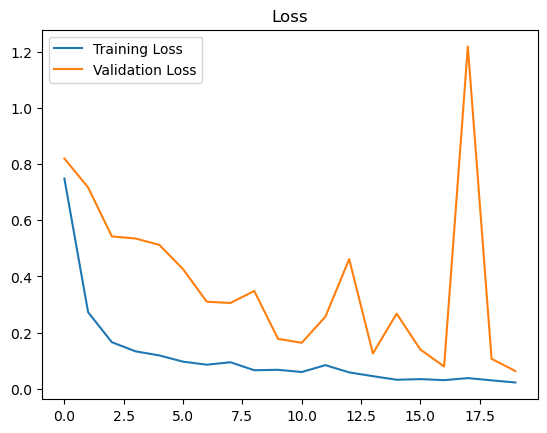

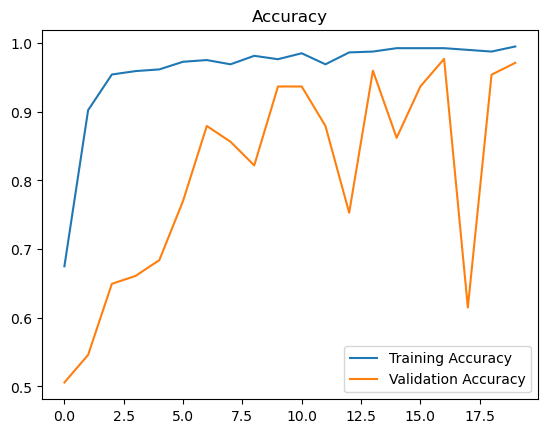

In [22]:
history = model.history.history
for key in history.keys():
    print(key)
    print(history[key])

plot_metrics(history) 

### Results

Experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 17th iteration with validation accuracy of ~98%

#### Load best model

In [25]:
best_model = load_model(filepath='models/cnn-parameters-improvement-17-0.98.model')

In [26]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data

In [27]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 3s 461ms/step - loss: 0.0850 - accuracy: 0.9711


Accuracy of the best model on the testing data

In [29]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.08503036201000214
Test Accuracy = 0.9710982441902161


F1 score for the best model on the testing data

In [30]:
y_test_prob = best_model.predict(X_test)

6/6 [==============================] - 1s 124ms/step


In [31]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9723756906077348


F1 score on the validation data

In [32]:
y_val_prob = best_model.predict(X_val)

6/6 [==============================] - 1s 122ms/step


In [33]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9767441860465116


### Results Interpretation


In [34]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [35]:
# the whole data
data_percentage(y)

Number of examples: 1156
Percentage of positive examples: 53.28719723183391%, number of pos examples: 616
Percentage of negative examples: 46.71280276816609%, number of neg examples: 540


In [36]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 809
Percentage of positive examples: 54.26452410383189%, number of pos examples: 439
Percentage of negative examples: 45.73547589616811%, number of neg examples: 370
Validation Data:
Number of examples: 174
Percentage of positive examples: 49.42528735632184%, number of pos examples: 86
Percentage of negative examples: 50.57471264367816%, number of neg examples: 88
Testing Data:
Number of examples: 173
Percentage of positive examples: 52.60115606936416%, number of pos examples: 91
Percentage of negative examples: 47.39884393063584%, number of neg examples: 82


### Conclusion

Now, the model detects covid-19 with:
- 97.10% accuracy on the test set.
- 0.97 f1 score on the test set.
These resutls are very good considering that the data is balanced.